IntSlider(value=700, description='Credit Score:', max=850, min=300, step=10)

IntText(value=75000, description='Annual Income ($):')

IntText(value=30000, description='Loan Amount ($):')

IntSlider(value=25, description='DTI Ratio:', min=1)

Dropdown(description='Employment Type:', options=('Salaried', 'Self-Employed'), value='Salaried')

Button(description='Check Loan Decision', style=ButtonStyle())

Output()


📊 Final Optimized Model Performance:
✅ Accuracy: 0.883

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     67681
           1       0.47      0.02      0.04      8924

    accuracy                           0.88     76605
   macro avg       0.68      0.51      0.49     76605
weighted avg       0.84      0.88      0.83     76605



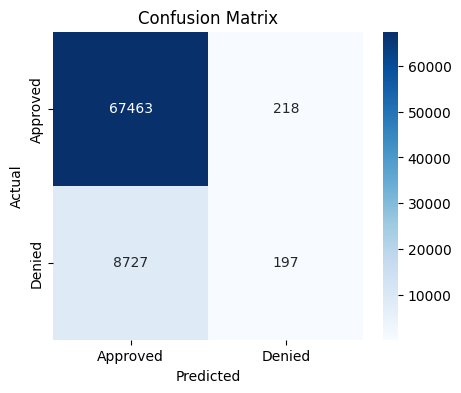

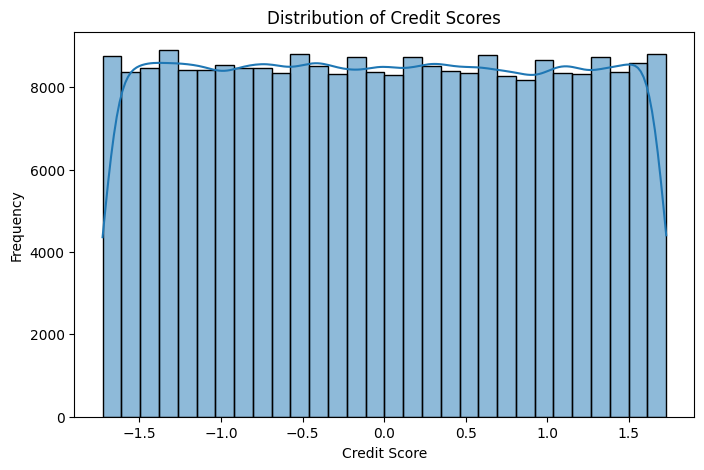

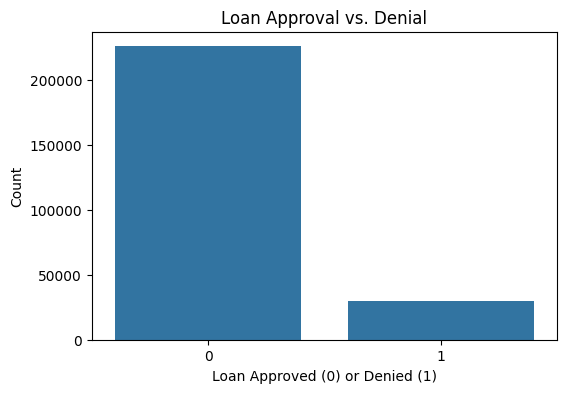

In [51]:
import pandas as pd
import numpy as np
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import datetime


# Load dataset
url = "https://raw.githubusercontent.com/kpatarawong/WGU-Capstone/refs/heads/main/Loan_default.csv"
df = pd.read_csv(url)

# Drop missing values
df.dropna(inplace=True)

# Feature Engineering: Add Loan-to-Income Ratio
df['LoanToIncome'] = df['LoanAmount'] / df['Income']

# Drop 'EmploymentType' from model training
if 'EmploymentType' in df.columns:
    df.drop(columns=['EmploymentType'], inplace=True)

# Define feature columns
features = ['CreditScore', 'Income', 'LoanAmount', 'DTIRatio', 'LoanToIncome']

# Convert features to float before applying transformations (Fixes FutureWarning)
df[features] = df[features].astype(np.float64)

# Feature Scaling: Apply StandardScaler
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Split dataset
X = df[features]
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Train Optimized Model
# Train Random Forest model with improved parameters
rf_model = RandomForestClassifier(
    n_estimators=50,  # Increased number of trees
    max_depth=10,  # Optimized depth for better generalization
    class_weight={0: 1, 1: 1.3},  # Adjusted to improve recall
    min_samples_split=5,  # Prevents overfitting
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(rf_model, "loan_model_optimized.pkl")


# Interactive GUI (Button-Based)
# Load trained model
model = joblib.load("loan_model_optimized.pkl")

# Create interactive widgets
credit_score_slider = widgets.IntSlider(value=700, min=300, max=850, step=10, description="Credit Score:")
income_input = widgets.IntText(value=75000, description="Annual Income ($):")
loan_amount_input = widgets.IntText(value=30000, description="Loan Amount ($):")
dti_ratio_slider = widgets.IntSlider(value=25, min=1, max=100, step=1, description="DTI Ratio:")
employment_dropdown = widgets.Dropdown(options=["Salaried", "Self-Employed"], value="Salaried", description="Employment Type:")
predict_button = widgets.Button(description="Check Loan Decision")
output = widgets.Output()

# Function to log predictions
def log_prediction(credit_score, income, loan_amount, dti_ratio, decision):
    with open("loan_predictions.log", "a") as log_file:
        log_file.write(f"{datetime.datetime.now()}, CreditScore: {credit_score}, Income: {income}, LoanAmount: {loan_amount}, DTI: {dti_ratio}, Decision: {decision}\n")

# Function to make predictions
def predict_loan_approval(b):
    with output:
        clear_output(wait=True)

        # Get user inputs
        credit_score = credit_score_slider.value
        income = income_input.value
        loan_amount = loan_amount_input.value
        dti_ratio = dti_ratio_slider.value
        loan_to_income = loan_amount / income

        # Denial conditions
        reasons = []
        if credit_score < 650:
            reasons.append("Low Credit Score (< 650)")
        if dti_ratio > 45:
            reasons.append("High Debt-to-Income Ratio (> 45%)")

        if reasons:
            print("\n🏆 Loan Decision:")
            print("❌ Loan Denied - Reason(s): " + ", ".join(reasons))
            log_prediction(credit_score, income, loan_amount, dti_ratio, "Denied")
            return

        # Prepare data for prediction
        user_data = pd.DataFrame([[credit_score, income, loan_amount, dti_ratio, loan_to_income]], columns=features)
        user_data_scaled = pd.DataFrame(scaler.transform(user_data), columns=features)

        # Predict using the ML model
        probability = model.predict_proba(user_data_scaled)[:, 1]
        threshold = 0.50  # Adjust threshold if needed
        prediction = (probability >= threshold).astype(int)

        print("\n🏆 Loan Decision:")
        if prediction[0] == 1:
            print("❌ Loan Denied - High Probability of Default")
            log_prediction(credit_score, income, loan_amount, dti_ratio, "Denied")
        else:
            print("✅ Loan Approved - Low Risk of Default")
            log_prediction(credit_score, income, loan_amount, dti_ratio, "Approved")

predict_button.on_click(predict_loan_approval)

# Display UI
display(credit_score_slider, income_input, loan_amount_input, dti_ratio_slider, employment_dropdown, predict_button, output)


# Model Evaluation
# Evaluate Model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\n📊 Final Optimized Model Performance:")
print(f"✅ Accuracy: {accuracy:.3f}\n")
print(report)

# Display Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Approved', 'Denied'], yticklabels=['Approved', 'Denied'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Data Visualization
# Histogram of Credit Scores
plt.figure(figsize=(8, 5))
sns.histplot(df['CreditScore'], bins=30, kde=True)
plt.title("Distribution of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.show()

# Bar chart of loan approval rates
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Default'])
plt.title("Loan Approval vs. Denial")
plt.xlabel("Loan Approved (0) or Denied (1)")
plt.ylabel("Count")
plt.show()